# Programming Project #2: Image Quilting

## CS445: Computational Photography


In [560]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [561]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from random import random
import time



# modify to where you store your project data including utils.py
datadir = "/content/drive/My Drive/ImageQuilting/cs445_proj2_starter_code-2/"

utilfn = datadir + "utils.py"
!cp "$utilfn" .
samplesfn = datadir + "samples"
!cp -r "$samplesfn" .
import utils

In [562]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

In [563]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    randomSample = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    for out_r in range(0, out_size, patch_size):
      for out_c in range(0, out_size, patch_size):
        in_r = int(random() * (sample.shape[0] - patch_size))
        in_c = int(random() * (sample.shape[0] - patch_size))
        psr = patch_size
        psc = patch_size
        if((out_r + psr) > out_size):
          psr = out_size - out_r
        if((out_c + psc) > out_size):
          psc = out_size - out_c
        randomSample[out_r:(out_r+psr), out_c:(out_c+psc), :] = sample[in_r:(in_r+psr), in_c:(in_c+psc), :]


    return randomSample



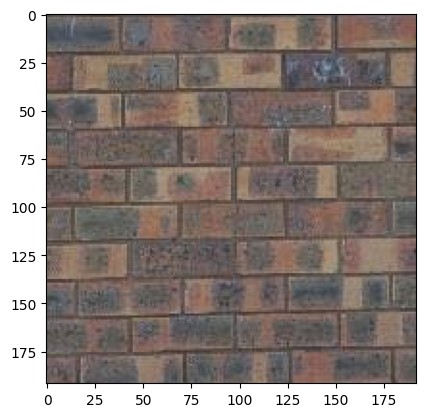

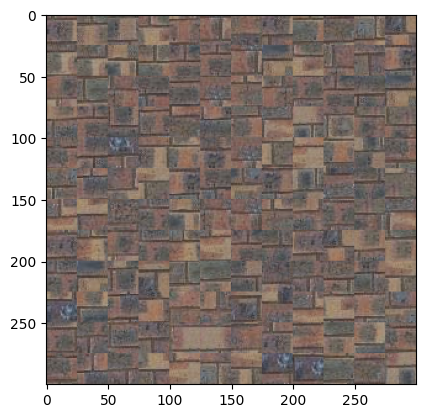

In [564]:
sample_img_fn = 'samples/bricks_small.jpg' # feel free to change
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 25
res = quilt_random(sample_img, out_size, patch_size)
if res is not None:
    plt.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [565]:
def ssd_patch(curPatch, bitMask, sampleImage):
  # Break down into TMI and create output cost image
  M = bitMask
  ssd_cost = np.zeros((sampleImage.shape[0], sampleImage.shape[1]))
  # Loop through each color channel and add cost of each to output cost image
  for i in range(3):
    # Normalize to [0, 1]
    T = curPatch[:, :, i]/255
    I = sampleImage[:, :, i]/255
    channelCost = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    ssd_cost += channelCost
  return ssd_cost

In [566]:
def choose_sample(costImage, tol, patchWidth, patchHeight):
  i = costImage.shape[0]
  j = costImage.shape[1]
  # Ignore values that would select a patch that would result going out of the image
  costImage[0:patchWidth//2, :] = np.inf
  costImage[:, 0:patchHeight//2] = np.inf
  costImage[i - patchWidth//2:i, :] = np.inf
  costImage[:, j - patchHeight//2:j] = np.inf
  # Get lowest tol indicies
  lowestTolIndicies = (np.argsort(costImage.flatten()))[0:tol]
  # Randomly pick one
  lowestTolIndex = lowestTolIndicies[int(random() * len(lowestTolIndicies))]
  # Convert index from 1d to 2d using original i and j (rows and cols)
  rowIndex = lowestTolIndex // j
  colIndex = lowestTolIndex % j
  return [rowIndex, colIndex]


In [567]:
def quilt_simple(sample, out_size, patch_size, overlap, tol):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    # Create return image
    simpleSample = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    ps = patch_size
    # Create initial random starting patch
    in_r = int(random() * (sample.shape[0] - ps))
    in_c = int(random() * (sample.shape[0] - ps))
    simpleSample[0:ps, 0:ps, :] = sample[in_r:(in_r + ps), in_c:(in_c + ps), :]
    # Get a cheap overlapping patch for each subsequent one
    for i in range(0, out_size, ps - overlap):
      for j in range(0, out_size, ps - overlap):
        if(i == 0 and j == 0):
          continue;
        # Get patch of valid size
        psr = patch_size
        psc = patch_size
        if((i + psr) > out_size):
          psr = out_size - i
        if((j + psc) > out_size):
          psc = out_size - j
        outputPatch = simpleSample[i:(i+psr), j:(j+psc), :]
        # Get bit mask of proper size
        bitMask = np.zeros((psr, psc))
        if (i > 0):
          bitMask[0:overlap, :] = 1
        if (j > 0):
          bitMask[:, 0:overlap] = 1
        # Get SSD costs for specified patch
        ssd = ssd_patch(outputPatch, bitMask, sample)
        # Get cheapest coordinates to place a patch
        cheapCoords = choose_sample(ssd, tol, psr, psc)
        # Place cheapest patch
        in_r = cheapCoords[0] - psr//2
        in_c = cheapCoords[1] - psc//2
        simpleSample[i:(i + psr), j:(j + psc), :] = sample[in_r:(in_r + psr), in_c:(in_c + psc), :]
    return simpleSample





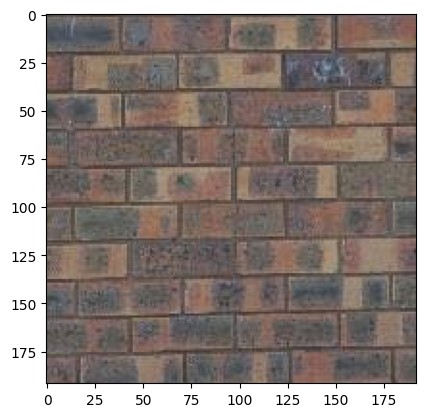

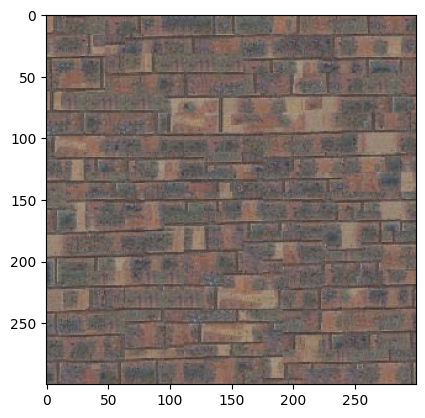

In [568]:
sample_img_fn = 'samples/bricks_small.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300 # change these parameters as needed
patch_size = 21
overlap = 5
tol = 6
res = quilt_simple(sample_img, out_size, patch_size, overlap, tol) #feel free to change parameters to get best results
if res is not None:
    plt.imshow(res)

### Part III: Seam Finding (20 pts)


In [569]:
# optional or use cut(err_patch) directly
def getOverlapError(outputImageOverlap, newPatchOverlap):
  # Normalize the two images to be [0, 1]
  normalizedImg1 = outputImageOverlap/255.0
  normalizedImg2 = newPatchOverlap/255.0
  # Get sum across three color channels
  ssd_cost = np.sum(((normalizedImg1 - normalizedImg2)**2), axis=2)
  return ssd_cost

In [570]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    test = True
    # Create return image
    cutSample = np.zeros((out_size, out_size, sample.shape[2]), dtype=sample.dtype)
    ps = patch_size
    # Create initial random starting patch
    in_r = int(random() * (sample.shape[0] - ps))
    in_c = int(random() * (sample.shape[0] - ps))
    cutSample[0:ps, 0:ps, :] = sample[in_r:(in_r + ps), in_c:(in_c + ps), :]
    # Get a cheap overlapping patch for each subsequent one
    for i in range(0, out_size, ps - overlap):
      for j in range(0, out_size, ps - overlap):
        if(i == 0 and j == 0): continue
        # Get patch of valid size
        psr = ps
        psc = ps
        if((i + psr) > out_size):
          psr = out_size - i
        if((j + psc) > out_size):
          psc = out_size - j
        outputPatch = cutSample[i:(i+psr), j:(j+psc), :]
        # Get bit mask of proper size
        bitMask = np.zeros((psr, psc))
        if (i > 0):
          bitMask[0:overlap, :] = 1
        if (j > 0):
          bitMask[:, 0:overlap] = 1
        # Get SSD costs for specified patch
        ssd = ssd_patch(outputPatch, bitMask, sample)
        # Get cheapest coordinates to place a patch
        cheapCoords = choose_sample(ssd, tol, psr, psc)
        in_r = cheapCoords[0] - psr//2
        in_c = cheapCoords[1] - psc//2
        # Begin most optimal cut process
        horCutError = []
        verCutError = []
        horCutOutput = []
        verCutOutput = []
        errorMask = np.ones((psr, psc))
        # If in bounds for getting the horizontal error region, get it and find the overlap error
        if(j + psc - overlap > 0 and in_c + overlap < sample.shape[1] and j != 0 and overlap < psc):
          outputImgOverlap = cutSample[i:(i + psr), (j + psc - overlap):(j + psc), :]
          inputImgOverlap = sample[in_r:(in_r + psr), in_c:(in_c + overlap), :]
          # Apply cut function to get bitmap of values to slice and combine it with our error mask
          horCutError = getOverlapError(outputImgOverlap, inputImgOverlap)
          horCutOutput = cut(horCutError.T).T
          errorMask[0:psr, 0:overlap] *= horCutOutput
        # If in bounds for getting the vertical error region ...
        if(i + psr - overlap > 0 and in_r + overlap < sample.shape[1] and i != 0 and overlap < psr):
          outputImgOverlap = cutSample[(i + psr - overlap):(i + psr), j:(j + psc), :]
          inputImgOverlap = sample[in_r:(in_r + overlap), in_c:(in_c + psc), :]
          # Apply cut function to get bitmap of values to slice and combine it with our error mask
          verCutError = getOverlapError(outputImgOverlap, inputImgOverlap)
          verCutOutput = cut(verCutError)
          errorMask[0:overlap, 0:psc] *= verCutOutput
        # if(i > 0 and j > 0 and test == True):
        #   test = False
        #   printCurrent = cutSample[i:(i + psr), j:(j + psc), :]
        #   plt.imshow(horCutError)
        #   plt.show()
        #   plt.imshow(verCutError)
        #   plt.show()
        #   plt.imshow(horCutOutput, cmap='gray')
        #   plt.show()
        #   plt.imshow(verCutOutput, cmap='gray')
        #   plt.show()
        #   plt.imshow(errorMask, cmap='gray')
        #   plt.show()
        #   plt.imshow(printCurrent)
        #   plt.show()
        #   plt.imshow(cutSample)
        #   plt.show()
        # Place masked (cut) cheapest patch
        cutSample[i:(i + psr), j:(j + psc), :][errorMask == 1] = sample[in_r:(in_r + psr), in_c:(in_c + psc), :][errorMask == 1]
    return cutSample


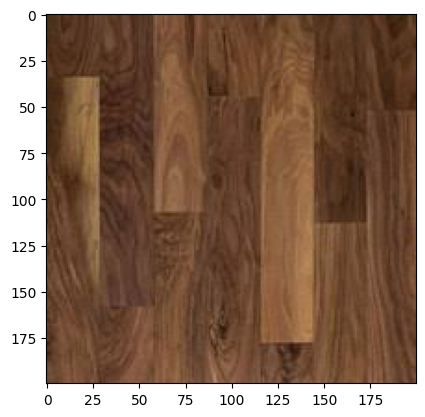

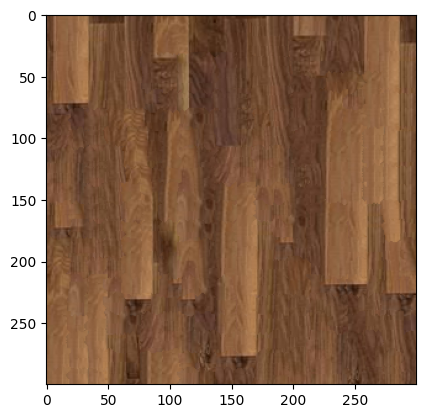

In [571]:
sample_img_fn = 'samples/wood.jpg'
sample_img = cv2.cvtColor(cv2.imread(sample_img_fn), cv2.COLOR_BGR2RGB)
plt.imshow(sample_img)
plt.show()

out_size = 300  # change these parameters as needed
patch_size = 20
overlap = 5
tol = 1
res = quilt_cut(sample_img, out_size, patch_size, overlap, tol)
if res is not None:
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [572]:
def texture_transfer(texture_im, patch_size, overlap, tol, guidance_im, alpha):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to modify function parameters
    :param sample: numpy.ndarray
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :param guidance_im: target overall appearance for the output
    :param alpha: float 0-1 for strength of target
    :return: numpy.ndarray
    """
    # Create return image
    rows = guidance_im.shape[0]
    cols = guidance_im.shape[1]
    transferSample = np.zeros((rows, cols, 3), dtype=guidance_im.dtype)
    ps = patch_size
    # Create initial random starting patch
    in_r = int(random() * (texture_im.shape[0] - ps))
    in_c = int(random() * (texture_im.shape[1] - ps))
    transferSample[0:ps, 0:ps, :] = texture_im[in_r:(in_r + ps), in_c:(in_c + ps), :]
    # Get a cheap overlapping patch for each subsequent one
    for i in range(0, rows, ps - overlap):
      for j in range(0, cols, ps - overlap):
        if(i == 0 and j == 0): continue
        # Get patch of valid size
        psr = ps
        psc = ps
        if((i + psr) > rows):
          psr = rows - i
        if((j + psc) > cols):
          psc = cols - j
        outputPatch = transferSample[i:(i+psr), j:(j+psc), :]
        guidancePatch = guidance_im[i:(i+psr), j:(j+psc), :]
        # Get bit mask of proper size
        bitMask = np.zeros((psr, psc))
        bitMask2 = np.zeros((psr, psc))
        if (i > 0):
          bitMask[0:overlap, :] = 1
          bitMask2[0:overlap, :] = 1
        if (j > 0):
          bitMask[:, 0:overlap] = 1
          bitMask2[0:overlap, :] = 1
        # Get SSD costs for specified patch
        ssd = ssd_patch(outputPatch, bitMask, texture_im)
        # Get correspondance map error
        secondSSD = ssd_patch(guidancePatch, bitMask2, texture_im)
        # New error cost
        newErrorCost = alpha * ssd + (1 - alpha) * secondSSD
        # Get cheapest coordinates to place a patch
        cheapCoords = choose_sample(newErrorCost, tol, psr, psc)
        in_r = cheapCoords[0] - psr//2
        in_c = cheapCoords[1] - psc//2
        # Begin most optimal cut process
        errorMask = np.ones((psr, psc))
        # If in bounds for getting the horizontal error region, get it and find the overlap error
        if(j + psc - overlap > 0 and in_c + overlap < texture_im.shape[1] and j != 0 and overlap < psc):
          outputImgOverlap = transferSample[i:(i + psr), (j + psc - overlap):(j + psc), :]
          inputImgOverlap = texture_im[in_r:(in_r + psr), in_c:(in_c + overlap), :]
          # Apply cut function to get bitmap of values to slice and combine it with our error mask
          horCutOutput = cut(getOverlapError(outputImgOverlap, inputImgOverlap).T).T
          errorMask[0:psr, 0:overlap] *= horCutOutput
        # If in bounds for getting the vertical error region ...
        if(i + psr - overlap > 0 and in_r + overlap < texture_im.shape[1] and i != 0 and overlap < psr):
          outputImgOverlap = transferSample[(i + psr - overlap):(i + psr), j:(j + psc), :]
          # Apply cut function to get bitmap of values to slice and combine it with our error mask
          inputImgOverlap = texture_im[in_r:(in_r + overlap), in_c:(in_c + psc), :]
          verCutOutput = cut(getOverlapError(outputImgOverlap, inputImgOverlap))
          errorMask[0:overlap, 0:psc] *= verCutOutput
        # Place masked (cut) cheapest patch
        transferSample[i:(i + psr), j:(j + psc), :][errorMask == 1] = texture_im[in_r:(in_r + psr), in_c:(in_c + psc), :][errorMask == 1]
    return transferSample


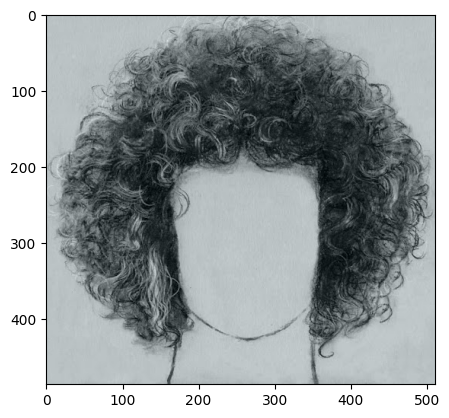

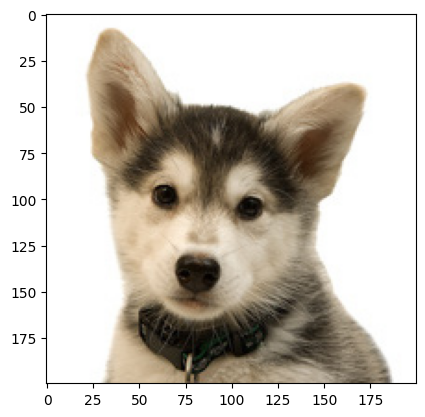

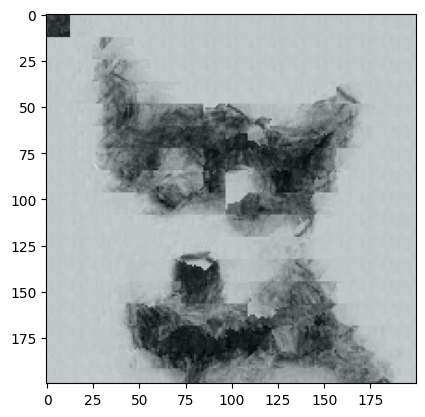

In [576]:
# load/process appropriate input texture and guidance images
texture_img = 'samples/hair.jpg'
texture_as_img = cv2.cvtColor(cv2.imread(texture_img), cv2.COLOR_BGR2RGB)
plt.imshow(texture_as_img)
plt.show()

guidance_img = 'samples/dog.jpg'
guidance_as_img = cv2.cvtColor(cv2.imread(guidance_img), cv2.COLOR_BGR2RGB)
plt.imshow(guidance_as_img)
plt.show()

patch_size = 25
overlap = 13
tol = 1
alpha = 0.1
res = texture_transfer(texture_as_img, patch_size, overlap, tol, guidance_as_img, alpha)

plt.imshow(res)
plt.show()

### Bells & Whistles

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).